# Connectome Graph Visualization and Debugging

I loaded the preprocessed connectome data (`graph_tensors.pt`) and used NetworkX and Matplotlib to visualize the graph structure. I focused on edge weights (Gap Junctions and Chemical Synapses) to debug inconsistencies, such as the reported asymmetric gap junction weights.

In [1]:
# Imports
import torch
import networkx as nx
import matplotlib.pyplot as plt
import os

## 1. Configuration and Loading Data

I set the path to the processed graph data file and loaded it.

In [2]:
# Define the root directory
ROOT_DIR = os.path.abspath('../../')

GRAPH_FILE_NAME = "graph_tensors_chklovskii.pt"
# Construct the path to the graph file
GRAPH_FILE_PATH = os.path.join(ROOT_DIR, "data", "processed", "connectome", GRAPH_FILE_NAME)

# Check if the file exists
if not os.path.exists(GRAPH_FILE_PATH):
    print(f"ERROR: Graph file not found at: {GRAPH_FILE_PATH}")
    print("Please ensure the path is correct and the preprocessing script has been run.")
    # Stop execution if file not found
    raise FileNotFoundError(f"Graph file not found at: {GRAPH_FILE_PATH}")
else:
    print(f"Loading graph data from: {GRAPH_FILE_PATH}")
    # Load the dictionary containing graph tensors and metadata
    graph_data = torch.load(GRAPH_FILE_PATH)
    print("Graph data loaded successfully.")


Loading graph data from: /Users/hectorastrom/Documents/School/MIT/UROP/celegans_ann_iap_2025/code/worm-data-preprocess/data/processed/connectome/graph_tensors_chklovskii.pt
Graph data loaded successfully.


## 2. Inspect Loaded Data

I displayed the available keys in the loaded dictionary and reported the shapes of the tensors.

In [3]:
print("Available keys in loaded data:", graph_data.keys())

# Extract key components
edge_index = graph_data.get('edge_index')
edge_attr = graph_data.get('edge_attr')
node_label = graph_data.get('node_label') # Maps index -> neuron name (e.g., {0: 'ADAL', ...})
pos = graph_data.get('pos') # Maps index -> [x, y, z] coordinates (or might be a tensor)
num_nodes = len(node_label) if node_label else (edge_index.max().item() + 1 if edge_index is not None else 0)

print(f"\nNumber of nodes (neurons): {num_nodes}")
if edge_index is not None:
    print(f"Shape of edge_index: {edge_index.shape}") # Should be [2, num_edges]
else:
    print("edge_index not found in data.")

if edge_attr is not None:
    print(f"Shape of edge_attr: {edge_attr.shape}") # Should be [num_edges, 2] (gap_weight, chem_weight)
    print(f"Data type of edge_attr: {edge_attr.dtype}")
else:
    print("edge_attr not found in data.")

if pos is not None:
    # Check if pos is a dictionary or tensor and report appropriately
    if isinstance(pos, dict):
        print(f"Position data ('pos') found as a dictionary for {len(pos)} nodes.")
    elif isinstance(pos, torch.Tensor):
         print(f"Position data ('pos') found as a tensor with shape: {pos.shape}")
    else:
        print(f"Position data ('pos') found with type: {type(pos)}")
else:
    print("Position data ('pos') not found. Will use a default layout.")

if node_label is not None:
    print(f"Node labels found for {len(node_label)} nodes.")
    # Create inverse mapping: name -> index
    neuron_to_idx = {name: idx for idx, name in node_label.items()}
else:
    print("Node labels ('node_label') not found.")
    neuron_to_idx = {}


Available keys in loaded data: dict_keys(['edge_index', 'edge_attr', 'pos', 'x', 'y', 'node_type', 'node_label', 'node_class', 'node_index', 'num_classes'])

Number of nodes (neurons): 300
Shape of edge_index: torch.Size([2, 90000])
Shape of edge_attr: torch.Size([90000, 2])
Data type of edge_attr: torch.float32
Position data ('pos') found as a tensor with shape: torch.Size([300, 3])
Node labels found for 300 nodes.


## 3. Build NetworkX Graph

I converted the PyTorch Geometric data into a NetworkX `DiGraph` (Directed Graph) to represent potential asymmetry in both chemical and (incorrectly) gap junctions. I stored the gap and chemical weights as edge attributes.

In [4]:
G = nx.DiGraph()

# Add nodes with labels
if node_label:
    for node_idx, node_name in node_label.items():
        G.add_node(node_idx, label=node_name)
else:
    # Add nodes without labels if node_label wasn't found
    G.add_nodes_from(range(num_nodes))
print(f"Added {G.number_of_nodes()} nodes to the NetworkX graph.")

# Add edges with attributes
num_edges_added = 0
if edge_index is not None and edge_attr is not None:
    if edge_index.shape[1] == edge_attr.shape[0]:
        for i in range(edge_index.shape[1]):
            source_node = edge_index[0, i].item()
            target_node = edge_index[1, i].item()
            gap_weight = edge_attr[i, 0].item()
            chem_weight = edge_attr[i, 1].item()

            # Add edge with individual weights as attributes
            G.add_edge(source_node, target_node, gap=gap_weight, chem=chem_weight)
            num_edges_added += 1
        print(f"Added {num_edges_added} edges to the NetworkX graph.")
    else:
        print(f"ERROR: Mismatch between edge_index columns ({edge_index.shape[1]}) and edge_attr rows ({edge_attr.shape[0]})")
else:
    print("Skipping edge addition as edge_index or edge_attr is missing.")

# Prepare positions for layout (using X and Y coordinates if available)
layout_pos = {}
if pos is not None:
    if isinstance(pos, dict):
         # Assuming dict maps index -> [x, y, z] or [x, y]
        for node_idx, coords in pos.items():
            if node_idx in G.nodes(): # Ensure node exists
                 layout_pos[node_idx] = coords[:2] # Take only X, Y for 2D plot
    elif isinstance(pos, torch.Tensor) and pos.shape[0] == num_nodes:
        # Assuming tensor where row i corresponds to node i
         for node_idx in G.nodes():
             layout_pos[node_idx] = pos[node_idx, :2].tolist() # Take X, Y
    else:
        print("Warning: 'pos' format not recognized or doesn't match nodes. Falling back to default layout.")
        layout_pos = None # Fallback
else:
    print("No position data found. Using NetworkX default layout (spring_layout).")
    layout_pos = None # Fallback

if not layout_pos: # If pos was missing or format failed
    print("Generating default spring layout...")
    layout_pos = nx.spring_layout(G)
    print("Layout generated.")



Added 300 nodes to the NetworkX graph.
Added 90000 edges to the NetworkX graph.


## 4. Define Visualization Function

I implemented a function to draw the graph, allowing focus on specific neurons and displaying edge weights.

In [5]:
def visualize_connectome(graph, layout, focus_neurons=None, show_edge_labels=True, label_threshold=0.1, figsize=(15, 15)):
    """
    Visualizes the connectome graph or a subgraph around focus neurons.

    Args:
        graph (nx.DiGraph): The NetworkX graph to visualize.
        layout (dict): Dictionary mapping node indices to (x, y) positions.
        focus_neurons (list, optional): List of neuron names (str) to focus on.
                                         If None, attempts to draw the whole graph.
                                         If provided, draws only these neurons and edges between them.
        show_edge_labels (bool): Whether to display edge weights as text.
        label_threshold (float): Minimum absolute weight (gap or chem) for an edge label to be shown.
        figsize (tuple): Figure size for the plot.
    """
    plt.figure(figsize=figsize)

    node_indices_to_draw = list(graph.nodes())
    subgraph = graph # Default to the full graph

    # --- Filtering / Subgraphing ---
    if focus_neurons and neuron_to_idx:
        focus_indices = [neuron_to_idx.get(name) for name in focus_neurons if neuron_to_idx.get(name) is not None]
        if not focus_indices:
            print(f"Warning: None of the focus neurons {focus_neurons} found in the dataset.")
        else:
            print(f"Focusing on neurons: {focus_neurons} (Indices: {focus_indices})")
            # Create subgraph containing only the specified nodes and edges *between* them
            subgraph = graph.subgraph(focus_indices).copy() # Use copy to avoid modifying original
            node_indices_to_draw = list(subgraph.nodes())

            # Update layout to only contain nodes in the subgraph
            layout = {node: pos for node, pos in layout.items() if node in node_indices_to_draw}
            if not layout: # If layout failed for subgraph nodes, generate new one
                 print("Generating layout for subgraph...")
                 layout = nx.spring_layout(subgraph)


    if not node_indices_to_draw:
        print("No nodes to draw.")
        plt.close() # Close the empty figure
        return

    # --- Node Drawing ---
    node_labels = nx.get_node_attributes(subgraph, 'label')
    nx.draw_networkx_nodes(subgraph, layout, node_size=300, node_color='skyblue', alpha=0.8)
    nx.draw_networkx_labels(subgraph, layout, labels=node_labels, font_size=8)

    # --- Edge Drawing ---
    edges_to_draw = list(subgraph.edges(data=True))
    if not edges_to_draw:
        print("No edges to draw in the selection.")
    else:
        # Separate edges by type for potential coloring (optional)
        gap_edges = [(u, v) for u, v, d in edges_to_draw if abs(d.get('gap', 0)) > 0.01]
        chem_edges = [(u, v) for u, v, d in edges_to_draw if abs(d.get('chem', 0)) > 0.01]
        # Draw edges (can customize color, width based on weights)
        nx.draw_networkx_edges(subgraph, layout, edgelist=gap_edges, edge_color='blue', alpha=0.4, arrows=True, arrowstyle='->', connectionstyle='arc3,rad=0.1')
        nx.draw_networkx_edges(subgraph, layout, edgelist=chem_edges, edge_color='red', alpha=0.4, arrows=True, arrowstyle='->', connectionstyle='arc3,rad=-0.1') # Opposite arc

        # --- Edge Labels ---
        if show_edge_labels:
            edge_labels = {}
            for u, v, data in edges_to_draw:
                gap_w = data.get('gap', 0)
                chem_w = data.get('chem', 0)
                label_parts = []
                # Only add label if weight is significant
                if abs(gap_w) >= label_threshold:
                     label_parts.append(f"G:{gap_w:.2f}")
                if abs(chem_w) >= label_threshold:
                     label_parts.append(f"C:{chem_w:.2f}")

                if label_parts: # Only add if there's something to show
                    edge_labels[(u, v)] = "\n".join(label_parts)

            if edge_labels:
                 nx.draw_networkx_edge_labels(subgraph, layout, edge_labels=edge_labels, font_size=7, font_color='black', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.1'))
            else:
                 print("No edge labels to draw above the threshold.")


    plt.title(f"Connectome Visualization (Focus: {focus_neurons if focus_neurons else 'All'})")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.axis('on') # Ensure axes are shown
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box') # Try to keep aspect ratio if using spatial layout
    plt.show()


## 5. Visualize Specific Connections

I used the visualization function to investigate the VD1/VD2 connection mentioned in the issue.

Focusing on neurons: ['VD1', 'VD2'] (Indices: [287, 292])
No edge labels to draw above the threshold.


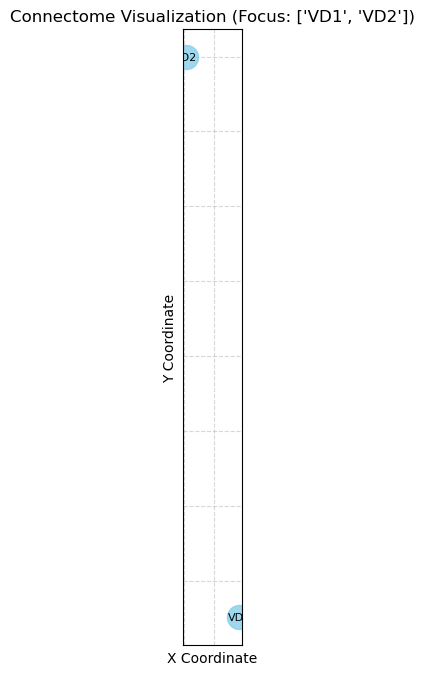

In [6]:
# Specify the neurons you want to focus on
neurons_of_interest = ['VD1', 'VD2']

# Check if these neurons exist in our mapping
missing_neurons = [n for n in neurons_of_interest if n not in neuron_to_idx]
if missing_neurons:
    print(f"Warning: The following neurons specified for focus were not found in the dataset: {missing_neurons}")

# Visualize the subgraph containing only these neurons and the direct connections *between* them
visualize_connectome(G, layout_pos, focus_neurons=neurons_of_interest, show_edge_labels=True, label_threshold=0.01, figsize=(8, 8))



**Interpreting the VD1/VD2 Plot:**

I examined the edges connecting VD1 and VD2. The labels show "G: [weight]" for gap junctions and "C: [weight]" for chemical synapses.

* For Gap Junction Symmetry: There should be two edges for a gap junction (one VD1 -> VD2, one VD2 -> VD1). Both should have the same "G:" value. If an edge VD1 -> VD2 has "G: 2.333" and VD2 -> VD1 has "G: 7.000", this visualization confirms the asymmetry reported in the issue.

* Chemical synapses ("C:") are expected to be asymmetric.

## 6. Visualize the Full Graph

I drew the full C. elegans connectome. The result is a very dense and unreadable "hairball" plot.

Attempting to visualize the full graph (may take time and be cluttered)...


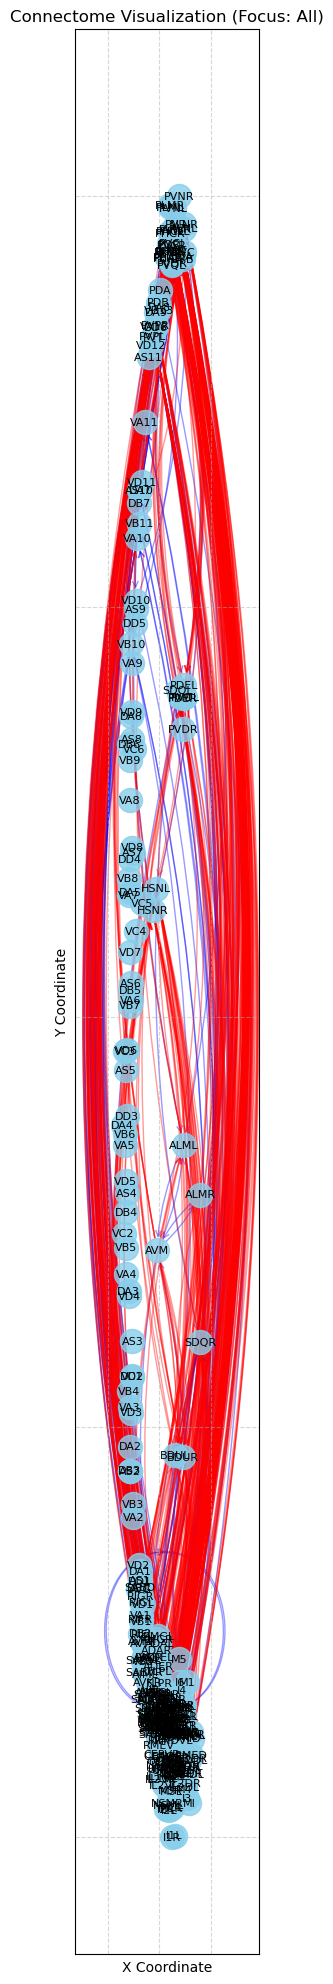

Full graph visualization attempted.


In [7]:
# # UNCOMMENT TO ATTEMPT FULL GRAPH VISUALIZATION (MAY BE SLOW/MESSY)

print("Attempting to visualize the full graph (may take time and be cluttered)...")
visualize_connectome(G, layout_pos, focus_neurons=None, show_edge_labels=False, figsize=(25, 25)) # Turn off edge labels for full graph
print("Full graph visualization attempted.")